In [1]:
import numpy as np
from PIL import Image
import os
from numpy import linalg as LA
from matplotlib import pyplot as plt

##### Data

In [43]:
data_path = "ORL-DATABASE"
train_images, test_images = [], []
for file in os.listdir(data_path):
    if not os.path.isdir(os.path.join(data_path, file)):
        continue
    subject_dir = os.path.join(data_path, file)
    for idx, face_dir in enumerate(os.listdir(subject_dir)):
        image_dir = os.path.join(subject_dir, face_dir)
        if idx < 5:
            train_images.append(plt.imread(image_dir))
        else:
            test_images.append(plt.imread(image_dir))
            
train_images = np.array(train_images, dtype='float64')
test_images = np.array(test_images, dtype='float64')

train_images_flatten = train_images.reshape(train_images.shape[0], -1)
test_images_flatten = test_images.reshape(test_images.shape[0], -1)

image_shape = train_images.shape[1:]

#### Average Face

In [44]:
def calculate_average_face(verbose=False):
    average_face = np.mean(train_images_flatten, axis=0)
    if verbose:
        plt.figure()
        plt.suptitle('Average Face')
        plt.imshow(average_face.reshape(*image_shape), cmap="gray")
        plt.show()
    return average_face

#### Normalizing Images & Training

In [17]:
def normalize_images(average_face, verbose=False):
    difference_faces = train_images_flatten - average_face
    if verbose:
        nums = np.random.randint(0,difference_faces.shape[0],5)
        plt.figure(figsize=(10,4))
        plt.suptitle('Normalized Faces')
        for i, elem in enumerate(difference_faces[nums]):
            plt.subplot(1,5,i+1)
            plt.imshow(elem.reshape(*image_shape), cmap="gray")
        plt.show()
    return difference_faces

def calculate_covariance(difference_faces):
    A = difference_faces.T
    L = np.dot(A.T, A)
    return L

##### Eigen Operations

In [79]:
def calculate_eigenvectors(L, N):
    eig_vals, v = LA.eig(L)
    v /= LA.norm(v, axis=0)

    p = np.argsort(eig_vals)[::-1]
    variance = np.sum(eig_vals[p][:N]) / np.sum(eig_vals)
    v, eig_vals = v[p][:N], eig_vals[p][:N]
    
    return v, eig_vals, variance

##### Eigen Faces

In [25]:
def generate_eigenfaces(v, difference_faces, verbose=False):
    if v.shape[0] < 20:
        verbose = False
    A = difference_faces.T
    eigen_faces = []
    if verbose:
        plt.figure(figsize=(10,10))
        plt.suptitle("Eigen Faces")
    for i, v_ in enumerate(v):
        uu = np.dot(A, v_)
        uu = uu / np.linalg.norm(uu)
        eigen_faces.append(uu)
        if verbose and i < 20:
            plt.subplot(4,5,i+1)
            plt.imshow(uu.reshape(*image_shape), cmap="gray")
    if verbose:
        plt.show()
    eigen_faces = np.array(eigen_faces).T
    return eigen_faces

def calculate_all_training_coeffs(average_face, eigen_faces):
    all_W = np.matmul(train_images_flatten - average_face, eigen_faces)
    return all_W

##### Reconstruct

In [26]:
def reconstruct(eigen_faces, average_face, all_W, recon_index=134, verbose=False):
    w = all_W[recon_index]
    reconst_im = (np.sum(eigen_faces * w, axis=1) + average_face).reshape(*image_shape)
    if verbose:
        plt.figure()
        plt.suptitle("Reconstructed Image / Original Image")
        plt.subplot(1,2,1)
        plt.imshow(reconst_im, cmap="gray")
        plt.subplot(1,2,2)
        plt.imshow(train_images[recon_index], cmap="gray")
        plt.show()
    return reconst_im

##### Classification

In [27]:
def classify(eigen_faces, average_face, all_W, classification_index=32):
    w_unknown = (test_images_flatten[classification_index] - average_face) @ eigen_faces
    same_index = np.argmin(np.linalg.norm((all_W - w_unknown), ord=2, axis=1))
    return same_index

##### Main Functions

In [76]:
def example_main():
    average_face = calculate_average_face(verbose=True)
    difference_faces = normalize_images(average_face, verbose=True)
    L = calculate_covariance(difference_faces)
    v, eig_vals, variance = calculate_eigenvectors(L, N=40)
    eigen_faces = generate_eigenfaces(v, difference_faces, verbose=True)
    all_W = calculate_all_training_coeffs(average_face, eigen_faces)
    reconst_im = reconstruct(eigen_faces, average_face, all_W, recon_index=134, verbose=True)
    same_index = classify(eigen_faces, average_face, all_W, classification_index=32)

In [82]:
def accuracy_for_different_dims():
    average_face = calculate_average_face(verbose=False)
    difference_faces = normalize_images(average_face, verbose=False)
    L = calculate_covariance(difference_faces)
    correct_nums, variances = [], []
    dims = np.linspace(5,200,40, dtype=int)
    for dim in dims:
        correct_num = 0
        v, eig_vals, variance = calculate_eigenvectors(L, N=dim)
        eigen_faces = generate_eigenfaces(v, difference_faces, verbose=False)
        all_W = calculate_all_training_coeffs(average_face, eigen_faces)
        for index, test_elem in enumerate(test_images):
            same_index = classify(eigen_faces, average_face, all_W, classification_index=index)
            if index // 5 == same_index // 5:
                correct_num += 1
        correct_nums.append(correct_num / 200)
        variances.append(variance)
    return np.array(correct_nums), dims, variances


In [84]:
correct_nums, dims, variances = accuracy_for_different_dims()

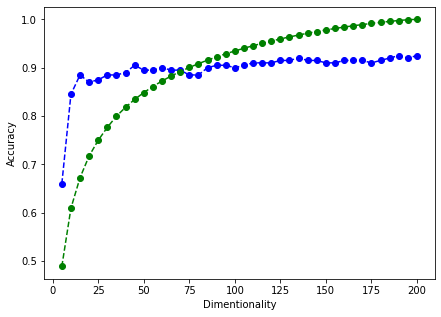

In [85]:
plt.figure(figsize=(7,5))
plt.xlabel("Dimentionality")
plt.ylabel("Accuracy")
plt.plot(dims, correct_nums, 'ob--')
plt.plot(dims, variances, 'og--')
plt.show()